# Actor-Critic RL: 2D Turbulence

In [1]:
using GeophysicalFlows, JLD2, Interpolations, Statistics

dev = CPU()
const n = 512 # grid resolution 
const L = 2π  # domain length    
const t_step = 0.005 # time-step of DNS data
const frame_max=1230 # number of frames

##### Load Velocity Field #####
file = jldopen("../../../Data Generation/2d-turb-data.jld")
u_data = file["vel_x"]
v_data = file["vel_y"]
vort_data = file["vort"]
close(file)

##### Interpolations #####
itp_vort = interpolate(vort_data, BSpline(Linear(Periodic())))
itp_u = interpolate(u_data, BSpline(Linear(Periodic())))
itp_v = interpolate(v_data, BSpline(Linear(Periodic())))

etp_vort = extrapolate(itp_vort, Periodic())
etp_u = extrapolate(itp_u, Periodic())
etp_v = extrapolate(itp_v, Periodic())

function vort(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_vort(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

function velX(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_u(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

function velY(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_v(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

N_tile = 30 
δ = L/N_tile # grid size for tiling

xA = 1.4 # start point
yA = 3.0 
rA = 0.2

xB = 5.2 # finish point
yB = 1.8
rB = 0.2

u0 = maximum(sqrt.(u_data[:,:,1].^2+v_data[:,:,1].^2)) # background maximum velocity
Va = 0.3*u0 # agent's velocity
Δt = δ/(2*u0) # agent's reaction time
Na = 8 # number of actions

n_episodes = 5000 # number of episodes for evaluation
n_train = 500000 # number of episodes for training

T_free = sqrt((xB-xA)^2+(yB-yA)^2)/Va
T_max = 5*T_free

w_reward = 1.0 # weight in the reward function

# generate starting position
function start_point()
    ϕ = 2π*rand()
    r = rA*sqrt(rand())
    return xA+r*cos(ϕ), yA+r*sin(ϕ)
end

# checking that the agent did not hit the border or target
function is_terminal(x,y)
    if (x<=0)||(y<=0)||(x>=L)||(y>=L)
        return true
    elseif sqrt((xB-x)^2+(yB-y)^2)<=rB
        return true
    else
        return false
    end
end 

nothing

In [2]:
# here we integrate the equations of motion over an interval [t, t+Δt]
using OrdinaryDiffEq

function advection!(du, u, p, t)
    x, y = u
    θ = p
    du[1] = dx = velX(x,y,t) + Va*cos(θ)
    du[2] = dy = velY(x,y,t) + Va*sin(θ)
end

function next_state_eval(x, y, t, θ)
    tspan = (t, t+Δt)
    prob = ODEProblem(advection!, [x, y], tspan, θ)
    sol = solve(prob, Tsit5(), p = θ, reltol = 1e-12, abstol = 1e-12)
    return sol(t+Δt)[1], sol(t+Δt)[2]
end

# less accurate integration to increase training speed
n_steps = 10
dt = Δt/n_steps # integration time-step

function next_state(x, y, t, θ)
    x_star, y_star, t_star = x, y, t
    
    for i in 1:n_steps
        dx = dt*(velX(x_star, y_star, t_star) + Va*cos(θ))
        dy = dt*(velY(x_star, y_star, t_star) + Va*sin(θ))
        x_star += dx
        y_star += dy
        t_star += dt
    end
    
    return x_star, y_star    
end

nothing

In [3]:
# get the current state (s_x, s_y) based on the current position (x,y) 
function get_tile(x,y)
    return Int(ceil(x/δ)), Int(ceil(y/δ))
end

h = zeros(N_tile, N_tile, Na) # function for policy parametrization h[x-tile, y-tile, action]
w = zeros(N_tile, N_tile) # approximation for state-value function

# the set of possible actions N_a=8 
actions = [-3π/4, -π/2, -π/4, 0, π/4, π/2, 3π/4, π]

# return action according to the current policy
function choose_action(s_x::Int, s_y::Int)
    weights = exp.(h[s_x, s_y, :])
    return actions[findfirst(cumsum(weights) .> rand() * sum(weights))]
end

# return greedy action (used for policy evaluation after training)
function choose_greedy_action(s_x::Int, s_y::Int)
    return actions[argmax(h[s_x,s_y,:])]
end    

# policy, i.e. probabilities for different actions
function policy(s_x::Int, s_y::Int, action::Int)
    return exp(h[s_x, s_y, action])/sum(exp.(h[s_x,s_y,:]))    
end

# initialization of the state-function approximation:
# the further from the end point, the lower the expected return w[i,j]
sx_B, sy_B = get_tile(xB, yB)

for i in 1:N_tile
    for j in 1:N_tile
        w[i,j]= -sqrt((i-sx_B)^2 + (j-sy_B)^2)*δ/Va
    end
end

nothing

### RL Training

In [4]:
# we save total rewards
r_tracks = []

α_w = 0.01 # learning rate for value function
α_h = 0.005 # learning rate for policy

for i in 1:n_train
    r_points = []
    
    # log to monitor training progress
    if i%50000==0
        println("i=",i)
    end

    x_now, y_now = start_point()
    step = 0
    
    while (is_terminal(x_now, y_now)==false)&&(step*Δt<T_max)        
        sx_now, sy_now = get_tile(x_now, y_now)
        θ_now = choose_action(sx_now,sy_now)
        action_num = round(Int,Na/2)+round(Int, Na*θ_now/(2*π))
     
        x_next, y_next = next_state(x_now, y_now, step*Δt, θ_now)
        step+=1
        
        reward = -Δt + w_reward*(sqrt((xB-x_now)^2+(yB-y_now)^2)/Va - sqrt((xB-x_next)^2+(yB-y_next)^2)/Va)
        
        # checking that the agent did not hit the border
        if (x_next<=0)||(y_next<=0)||(x_next>=L)||(y_next>=L)
            reward=reward-2*T_max
        end
        
        push!(r_points, reward)
        
        # Learning Part        
        sx_next, sy_next = get_tile(x_next, y_next)
        delta = reward
        
        if (sx_next>N_tile)||(sx_next<1)||(sy_next>N_tile)||(sy_next<1)
            delta = delta - w[sx_now, sy_now]
        else
            delta = delta + w[sx_next, sy_next] - w[sx_now, sy_now]
        end
                 
        w[sx_now, sy_now] += α_w*delta
        
        for j in 1:Na
            if j==action_num
                h[sx_now, sy_now, action_num] += α_h*delta*(1 - policy(sx_now, sy_now, action_num))
            else
                h[sx_now, sy_now, j] += -α_h*delta*policy(sx_now, sy_now, j)
            end
        end
        
        x_now, y_now = x_next, y_next 
    end

    push!(r_tracks, sum(r_points))
    
end

i=50000
i=100000
i=150000
i=200000
i=250000
i=300000
i=350000
i=400000
i=450000
i=500000


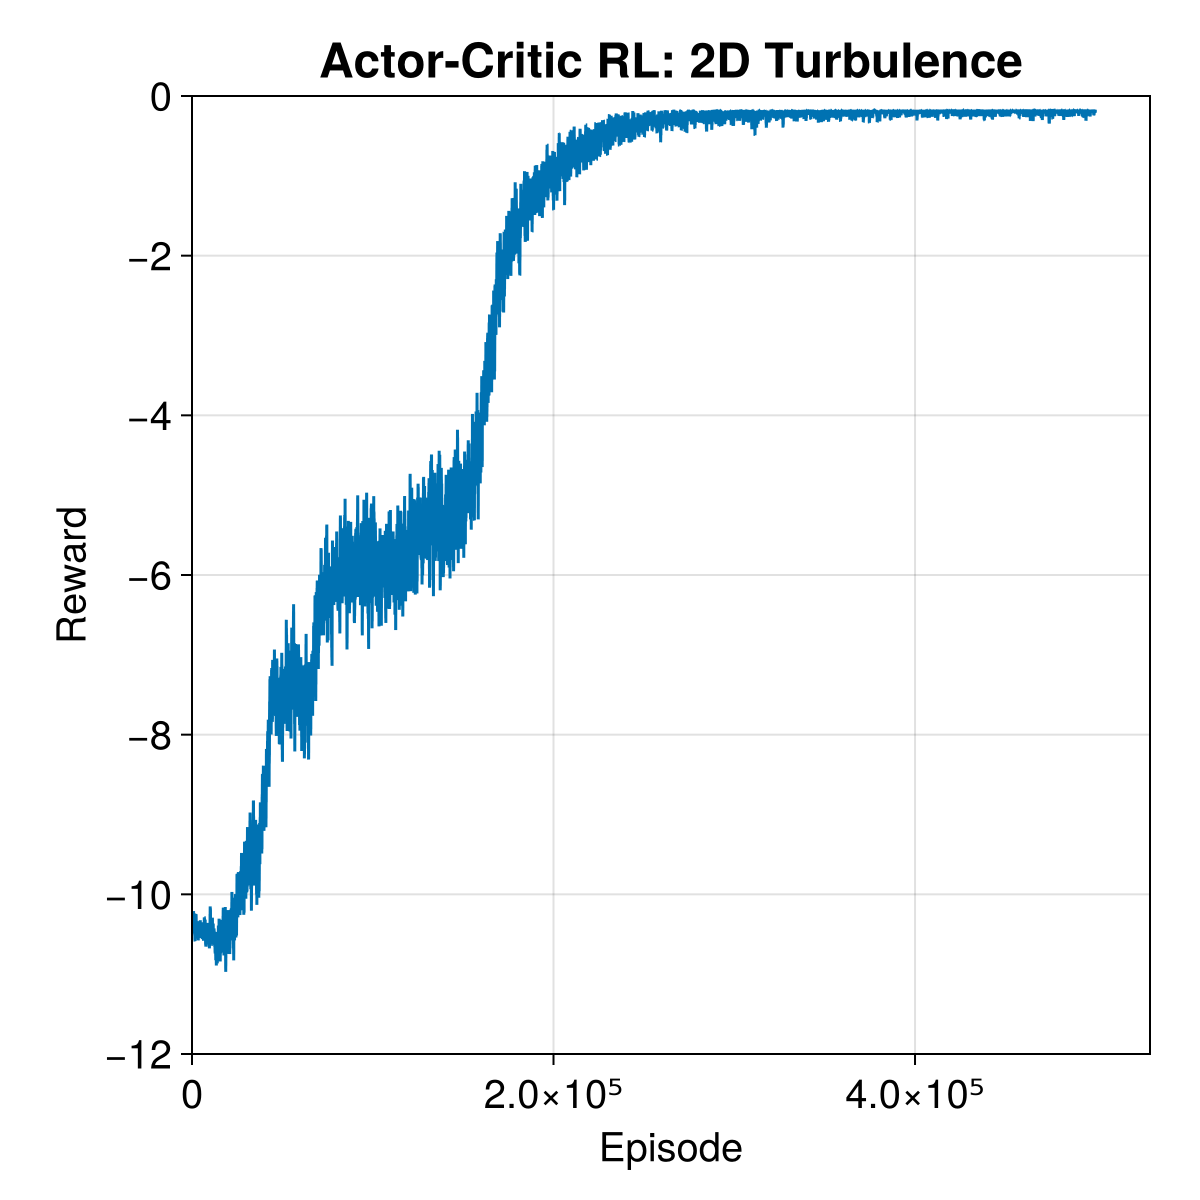

In [5]:
# Learning Progress: Reward vs. Episode Number
using CairoMakie

moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

fig = Figure(size = (600, 600))

ax = Axis(fig[1, 1],
    title = "Actor-Critic RL: 2D Turbulence", titlesize=24,
    xlabel = "Episode", xlabelsize=20, xticklabelsize=20,
    ylabel = "Reward", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, 1.06*n_train), (-12, 0))
)

lines!(ax, moving_average(r_tracks,250))

save("2d-turb-time + reward.pdf", fig)
fig

### Optimal Trajectory

In [6]:
using ForwardDiff

##### Derivatives #####
velX_x(x,y,t) = ForwardDiff.derivative(z -> velX(z, y, t), x)
velX_y(x,y,t) = ForwardDiff.derivative(z -> velX(x, z, t), y)
velY_x(x,y,t) = ForwardDiff.derivative(z -> velY(z, y, t), x)
velY_y(x,y,t) = ForwardDiff.derivative(z -> velY(x, z, t), y)

function TURB_advection!(du, u, p, t)
    x, y, z = u
    T = p[2]
    du[1] = dx = T*velX(x,y,t*T) + Va*T*cos(z)
    du[2] = dy = T*velY(x,y,t*T) + Va*T*sin(z)
    du[3] = dz = T*(velY_x(x,y,t*T)*sin(z)*sin(z) - velX_y(x,y,t*T)*cos(z)*cos(z) + sin(z)*cos(z)*(velX_x(x,y,t*T)-velY_y(x,y,t*T)))
end

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

p_opt = [-0.6200950940593796, 1.080000018047429]
prob_opt = ODEProblem(TURB_advection!, [xA, yA, p_opt[1]], tspan, p_opt)
opt_solution = solve(prob_opt, p = p_opt, saveat = tsteps, reltol = 1e-16, abstol = 1e-16)

# array for optimal track
x_opt_track = []
y_opt_track = []

# points for optimal track
x_opt_points = []
y_opt_points = []

T = p_opt[2]

for i in 0:floor(Int, T/Δt)
    x_now, y_now = opt_solution(i*Δt/T)[1], opt_solution(i*Δt/T)[2]
    push!(x_opt_points, x_now)
    push!(y_opt_points, y_now)
end

push!(x_opt_track, x_opt_points)
push!(y_opt_track, y_opt_points)

nothing

### Evaluation of Learned Policy

In [7]:
x_tracks_EV = []
y_tracks_EV = []
θ_tracks_EV = []
r_tracks_EV = []

success_EV = ones(n_episodes)

for i in 1:n_episodes
    x_points_EV = []
    y_points_EV = []
    θ_points_EV = []
    r_points_EV = []

    x_now, y_now = start_point()
    step = 0

    while (is_terminal(x_now, y_now)==false)&&(step*Δt<T_max)        
        sx_now, sy_now = get_tile(x_now, y_now)
        θ_now = choose_greedy_action(sx_now,sy_now)

        push!(x_points_EV, x_now)
        push!(y_points_EV, y_now)
        push!(θ_points_EV, θ_now)
        
        x_next, y_next = next_state_eval(x_now, y_now, step*Δt, θ_now)
        step+=1
        
        reward = -Δt + w_reward*(sqrt((xB-x_now)^2+(yB-y_now)^2)/Va - sqrt((xB-x_next)^2+(yB-y_next)^2)/Va)
        
        if (x_next<=0)||(y_next<=0)||(x_next>=L)||(y_next>=L)
            reward=reward-2*T_max
            success_EV[i]=0
        elseif step*Δt>=T_max
            success_EV[i]=0
        end
        
        push!(r_points_EV, reward)
        
        x_now, y_now = x_next, y_next 
    end

    # end of episode
    if is_terminal(x_now, y_now)==true
        push!(x_points_EV, x_now)
        push!(y_points_EV, y_now)
    end
    
    push!(x_tracks_EV, x_points_EV)
    push!(y_tracks_EV, y_points_EV)
    push!(θ_tracks_EV, θ_points_EV)
    push!(r_tracks_EV, sum(r_points_EV))
    
end

i = 100
i = 200


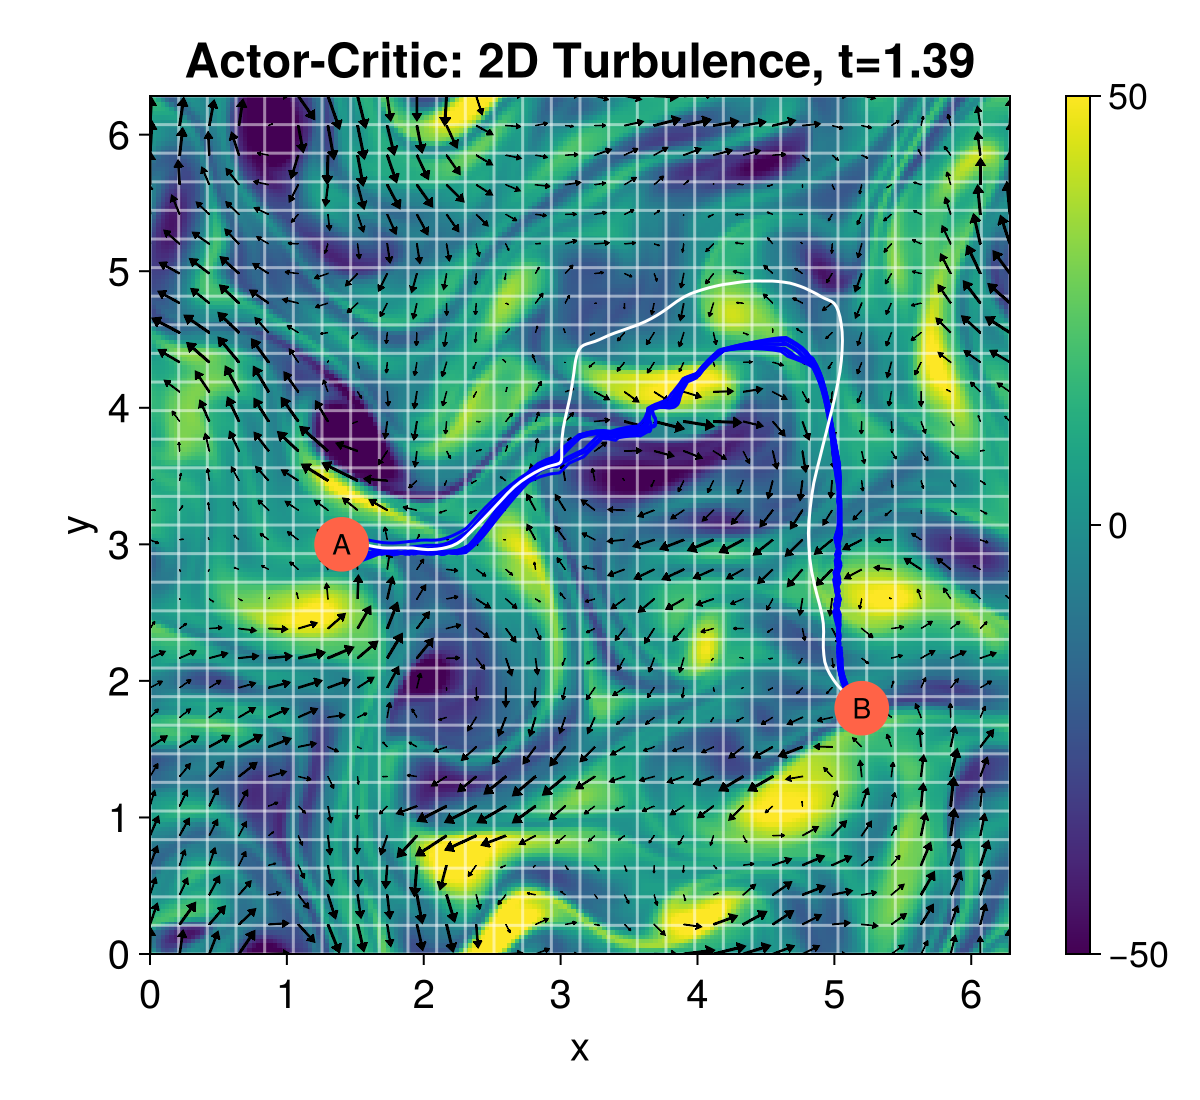

In [8]:
using CairoMakie, Printf

frame = Observable(1)
tau = @lift(($frame-1)*Δt)

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = @lift([vort(x,y, $tau) for x in xs, y in ys])
    
xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = @lift([velX(x,y, $tau) for x in xs2, y in ys2])
vs2 = @lift([velY(x,y, $tau) for x in xs2, y in ys2])

points_list = Any[]
opt_list = Any[]

for p in 1:10
    points = Observable(Point2f[(xA, yA)])
    push!(points_list, points)
end

push!(opt_list, Observable(Point2f[(xA, yA)]))

fig = Figure(size = (600, 550))

ax = Axis(fig[1, 1],
    title = @lift("Actor-Critic: 2D Turbulence, t="*@sprintf("%.2f", $tau)), titlesize=24,
    xlabel = "x", xlabelsize=20, xticklabelsize=20,
    ylabel = "y", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, L), (0,L))
)

hm = heatmap!(ax, xs, ys, zs, colormap = :viridis, alpha=1.0, colorrange=(-50, 50))
Colorbar(fig[:, end+1], hm, ticklabelsize=18)

hlines!(ax, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for p in 1:10
    lines!(ax, points_list[p], color=:blue)
end

lines!(ax, opt_list[1], color=:white)
    
poly!(ax, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center))

poly!(ax, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center))  

frames = 1:200

record(fig, "2d-turb-time -- tracks.mp4", frames; framerate = 20) do i
    mod(i, 100) == 0 && @show i
    frame[] = i    
    for (idx, points) in enumerate(points_list)
        if i<=length(x_tracks_EV[idx])
            new_point = Point2f(x_tracks_EV[idx][i], y_tracks_EV[idx][i])
            points[] = push!(points[], new_point)
        end
    end
    # optimal trajectory
    for (idx, points) in enumerate(opt_list)
        if i<=length(x_opt_track[idx])
            new_point = Point2f(x_opt_track[idx][i], y_opt_track[idx][i])
            points[] = push!(points[], new_point)
        end
    end
end

save("2d-turb-time + tracks.pdf", fig)
fig

Fail Probabitity = 0.0
Average Reward = -0.17425148550696667
Average Success Time = 1.0310499960752622


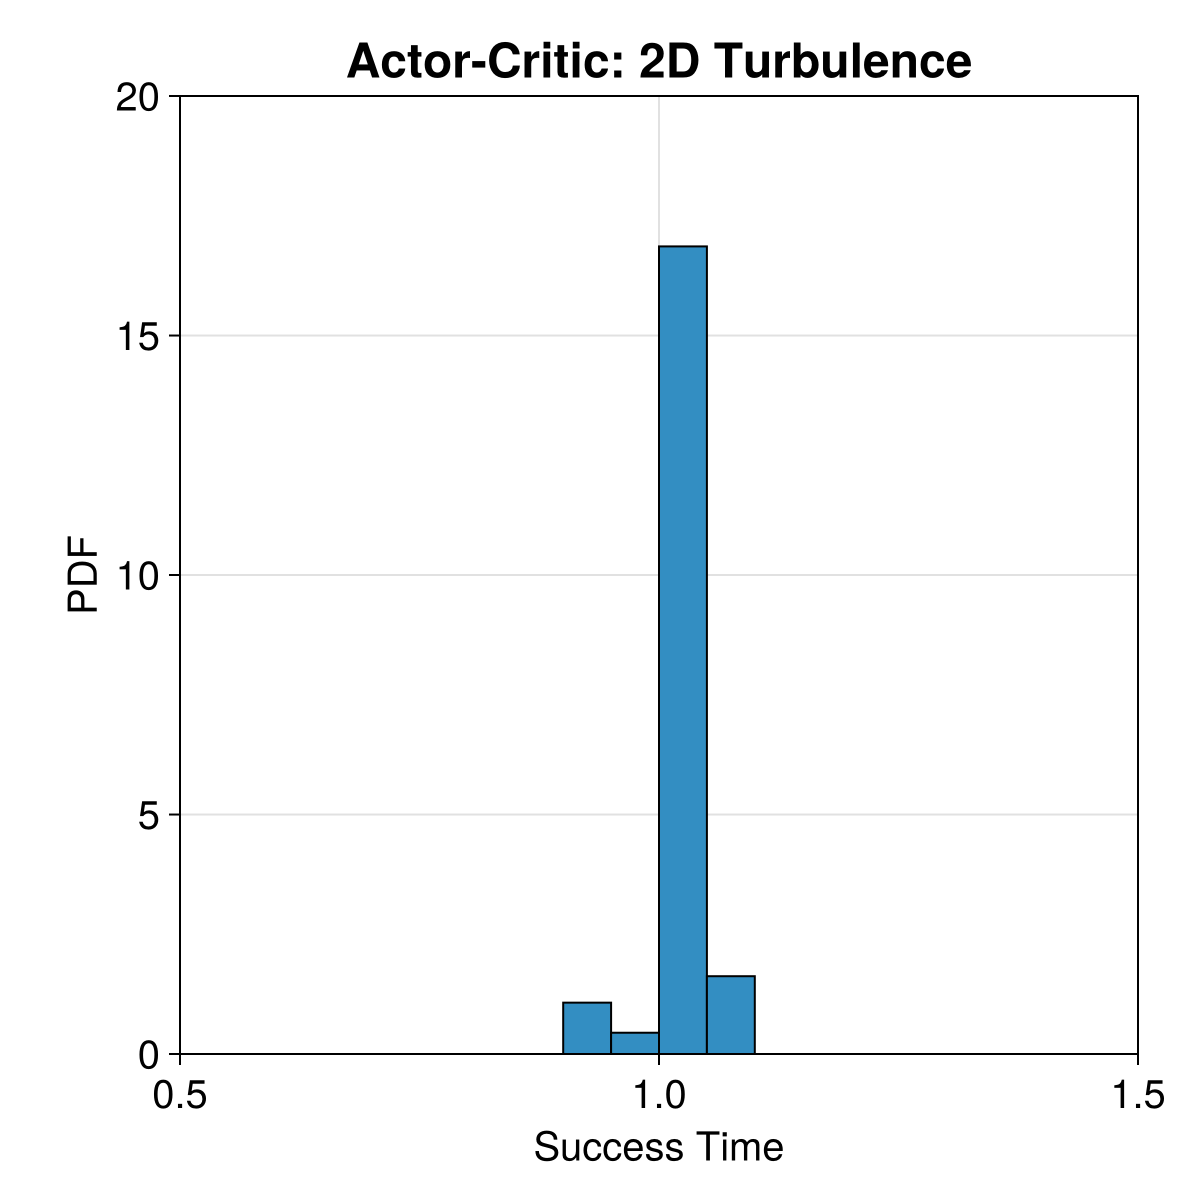

In [9]:
using Statistics

times_EV = zeros(Int(sum(success_EV)))
count_EV = 0

for i in 1:n_episodes
    if success_EV[i]==1
        count_EV+=1
        times_EV[count_EV] = length(x_tracks_EV[i])*Δt
    end
end
    
println("Fail Probabitity = ", 1-sum(success_EV)/n_episodes)
println("Average Reward = ", sum(r_tracks_EV)/n_episodes)
println("Average Success Time = ", mean(times_EV))

fig = Figure(size = (600, 600))

ax = Axis(fig[1, 1],
    title = "Actor-Critic: 2D Turbulence", titlesize=24,
    xlabel = "Success Time", xlabelsize=20, xticklabelsize=20,
    ylabel = "PDF", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0.5, 1.5), (0,20))
)

hist!(ax, times_EV, normalization = :pdf, bins=0.5:0.05:1.5, strokewidth = 1, strokecolor = :black)

save("2d-turb-time + success times.pdf", fig)
fig

In [10]:
# save results to file
using JLD2

jldsave("AC_data_time.jld2"; h, w, r_tracks, x_tracks_EV, y_tracks_EV, θ_tracks_EV,
        r_tracks_EV, success_EV, times_EV) 